### 분석준비

In [2]:
# 필요 라이브러리

# 분석을 위한 라이브러리
import numpy as np
import pandas as pd

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os

# 에러메세지 안나오게
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)

#워드클라우드
from wordcloud import WordCloud 
from PIL import *

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from nltk.tokenize.regexp import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [3]:
# 그래프 글씨 한글
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [4]:
# 디비 연결
import psycopg2
import json

def rds_python_conn():
    # rds와 python 연동을 위한 정보 입력
    with open('postgres.info.json','r') as json_file:
        db_info = json.load(json_file)

    host = db_info.get('host')
    dbname = 'postgres' 
    user = 'postgres' 
    password = db_info.get('password')
    port = 5432

    connection = psycopg2.connect(host=host,
                                  dbname=dbname ,
                                  user=user ,
                                  password=password ,
                                  port=port)
    return connection

In [5]:
# reviews 테이블에서 order_id, review_score, review_comment_message만 추출
SQL = """
SELECT order_id, review_score, review_comment_message
FROM reviews
"""
reviews = pd.read_sql(SQL, rds_python_conn())


# order 테이블에서 order_id,customer_id,order_purchase_timestamp만 추출
SQL = """
SELECT order_id,customer_id,order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing') and order_purchase_timestamp<='2018-09-01'
"""
order = pd.read_sql(SQL, rds_python_conn())

In [6]:
# reviews와 order merge
revi = order.merge(reviews,on='order_id',how='left')
revi

,order_id,customer_id,order_purchase_timestamp,review_score,review_comment_message
0,13974,65773,2017-10-02 10:56:33,4.0,"Não testei o produto ainda, mas ele veio corre..."
1,83165,13301,2018-07-24 20:41:37,4.0,Muito bom o produto.
2,66104,44559,2018-08-08 08:38:49,5.0,None
3,64037,69256,2017-11-18 19:28:06,5.0,O produto foi exatamente o que eu esperava e e...
4,14183,35294,2018-02-13 21:18:39,5.0,None
...,...,...,...,...,...
98739,63791,92532,2017-03-09 09:54:05,5.0,None
98740,85704,30689,2018-02-06 12:58:58,4.0,So uma peça que veio rachado mas tudo bem rs
98741,19817,23177,2017-08-27 14:46:43,5.0,Foi entregue antes do prazo.
98742,6896,84231,2018-01-08 21:28:27,2.0,Foi entregue somente 1. Quero saber do outro p...


In [8]:
revi[revi['review_comment_message'].isnull()]['review_score'].value_counts(normalize=True)

review_score
5.0    0.634594
4.0    0.226983
3.0    0.079158
1.0    0.042258
2.0    0.017007
Name: proportion, dtype: float64

In [9]:
(revi.review_score.value_counts(normalize=True)*100)

review_score
5.0    58.382647
4.0    19.482308
1.0    10.748684
3.0     8.260213
2.0     3.126148
Name: proportion, dtype: float64

In [10]:
(revi.review_score.value_counts(normalize=True)*100).sort_values(ascending=False).reset_index()

,review_score,proportion
0,5.0,58.382647
1,4.0,19.482308
2,1.0,10.748684
3,3.0,8.260213
4,2.0,3.126148


### 별점 비율

In [11]:
score_ratio = (revi.review_score.value_counts(normalize=True) * 100).sort_values(ascending=False).reset_index()
score_ratio['colors'] = ['#4A55A2', '#6A75BB', '#7895CB', '#A0BFE0', '#C5DFF8']

# 비율을 높은 순서대로 정렬
score_ratio = score_ratio.sort_values(by='review_score', ascending=False)

fig = px.bar(
    score_ratio,
    x='review_score',
    y='proportion',
    color='colors',  # 범주형 변수 컬럼 지정
    color_discrete_map=dict(zip(score_ratio['review_score'], score_ratio['colors']))
)

# 레이아웃 설정
fig.update_layout(
    title='별점 비율',  # 전체 그래프의 제목
    xaxis=dict(title='별점'),  # x축 레이블 설정
    yaxis=dict(title='비율'),  # y축 범위 설정
    width=800
)

fig.show()





### 워드클라우드

In [10]:
revi_ =revi[(revi['review_comment_message'].notnull())&(revi['review_score']<=2)] # 여기서 123점과 45점을 나눔.
revi_

,order_id,customer_id,order_purchase_timestamp,review_score,review_comment_message
6,5625,16101,2017-04-11 12:22:08,2.0,fiquei triste por n ter me atendido.
10,89094,32782,2017-05-16 19:41:10,1.0,Aguardando retorno da loja
20,69654,48736,2017-09-18 14:31:30,2.0,os correios estäo em greve... näo recebi nenhu...
25,61811,52133,2018-02-20 23:46:53,2.0,Demora muito entregar. Já passou o prazo e ain...
26,35035,36787,2018-06-04 00:00:13,1.0,Até o momento não recebi o produto Protetor De...
...,...,...,...,...,...
98706,69628,56757,2018-02-04 14:35:02,1.0,Não gostei imaginei que era uma cortina de tec...
98726,35099,21893,2017-10-12 20:54:11,1.0,nao recebi o produto que ja paguei ! nao recom...
98728,71978,54727,2018-03-21 19:47:18,1.0,"Prateleiras com cantos vivo, colunas nao encai..."
98735,73258,82399,2017-12-20 09:52:41,1.0,"Ele não é um mini cajon, é um shaker, ou seja,..."


In [11]:
def split_text(text):
    return text.lower().split()  # 공백을 기준으로 쪼개어 리스트로 변환

revi_['new_message'] = revi_['review_comment_message'].apply(split_text)

In [12]:
# 불용어 다운로드
nltk.download('stopwords')
nltk.download('punkt')

# 브라질 포르투갈어의 불용어 가져오기
stop_words = set(stopwords.words('portuguese'))

# 불용어 제거와 토큰화 수행
filtered_texts = []
for text_list in revi_['new_message']:
    filtered_text = [re.sub(r"[^\w\s]|produto", '', word) for word in text_list if word.lower() not in stop_words]
    filtered_text = [re.sub(r'\d', '', word) for word in filtered_text]  # 숫자 제거 및 빈 문자열 필터링
    filtered_texts.append(filtered_text)


# 결과 출력
all_ = []
for i in filtered_texts:
    for j in i:
        all_.append(j.strip())

[nltk_data] Downloading package stopwords to C:\Users\KIMJEONGSU.DESKT
[nltk_data]     OP-3GN3AD1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\KIMJEONGSU.DESKTOP-3
[nltk_data]     GN3AD1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
from collections import Counter

# 각 텍스트 리스트에서 단어 빈도수 계산
word_frequencies = Counter(all_)

# 상위권 50위
word_frequencies = word_frequencies.most_common(50)

# 단어와 빈도수로 구성된 리스트를 데이터프레임으로 변환
df_word_frequencies = pd.DataFrame(word_frequencies, columns=['Word', 'Frequency'])

In [14]:
dic_ = dict(word_frequencies)
dic_

{'': 10101,
 'recebi': 3069,
 'comprei': 1779,
 'veio': 1506,
 'ainda': 1312,
 'entrega': 1279,
 'entregue': 1242,
 'chegou': 1125,
 'nao': 859,
 'prazo': 830,
 'compra': 771,
 'pedido': 705,
 'dia': 698,
 'loja': 676,
 'agora': 615,
 'apenas': 533,
 's': 503,
 'dois': 483,
 'nada': 477,
 'pois': 465,
 'site': 465,
 'quero': 450,
 'lannister': 428,
 'contato': 426,
 'qualidade': 417,
 'outro': 412,
 'pra': 388,
 'aguardando': 386,
 'dias': 385,
 'porém': 374,
 'fiz': 360,
 'momento': 357,
 'correios': 343,
 'nota': 331,
 'duas': 326,
 'recomendo': 326,
 'paguei': 318,
 'resposta': 316,
 'receber': 305,
 'diferente': 305,
 'pedi': 289,
 'aguardo': 288,
 'problema': 286,
 'q': 285,
 'retorno': 282,
 'dinheiro': 268,
 'troca': 264,
 'vou': 263,
 'entregaram': 261,
 'errado': 261}

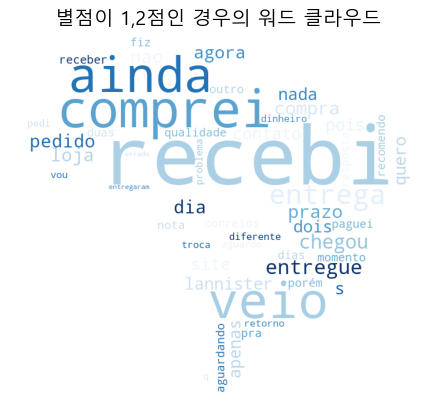

In [15]:
icon = Image.open('images.png')
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)




wordcloud = WordCloud(relative_scaling = 0.2,
                      background_color='white',
                      colormap='Blues' ,
                      mask=mask
                      ).generate_from_frequencies(dic_)
# plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('별점이 1,2점인 경우의 워드 클라우드',fontsize=14)
plt.show( )

### 리뷰와 부정리뷰 건수

In [16]:
SQL = """
SELECT order_id, payment_value
FROM payments

"""

payments = pd.read_sql(SQL, rds_python_conn())
payments

,order_id,payment_value
0,93586,99.33
1,2955,24.39
2,82474,65.71
3,55775,107.78
4,4054,128.45
...,...,...
103881,56307,363.31
103882,35667,96.80
103883,61044,47.77
103884,38153,369.54


In [17]:
SQL = """
SELECT order_id, review_score, review_comment_message
FROM reviews
"""

reviews = pd.read_sql(SQL, rds_python_conn())
reviews

,order_id,review_score,review_comment_message
0,64002,4,None
1,78339,5,None
2,25907,5,None
3,80635,5,Recebi bem antes do prazo estipulado.
4,72488,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99219,96979,5,None
99220,9999,5,None
99221,67181,5,"Excelente mochila, entrega super rápida. Super..."
99222,81384,4,None


In [18]:
SQL = """
SELECT order_id,customer_id,order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

order = pd.read_sql(SQL, rds_python_conn())
order

,order_id,customer_id,order_purchase_timestamp
0,13974,65773,2017-10-02 10:56:33
1,83165,13301,2018-07-24 20:41:37
2,66104,44559,2018-08-08 08:38:49
3,64037,69256,2017-11-18 19:28:06
4,14183,35294,2018-02-13 21:18:39
...,...,...,...
98195,63791,92532,2017-03-09 09:54:05
98196,85704,30689,2018-02-06 12:58:58
98197,19817,23177,2017-08-27 14:46:43
98198,6896,84231,2018-01-08 21:28:27


In [19]:
# 매출과 리뷰건수 비교
df = order.merge(reviews,on='order_id',how='left')
df2 = df.merge(payments,on='order_id',how='left')
df2['date'] = df2['order_purchase_timestamp'].dt.strftime('%Y-%m')
df5 = df2[(df2.review_score<3)&(df2.date<'2018-09')].drop_duplicates(subset=['order_id','order_purchase_timestamp','review_comment_message'])
df5

,order_id,customer_id,order_purchase_timestamp,review_score,review_comment_message,payment_value,date
8,5625,16101,2017-04-11 12:22:08,2.0,fiquei triste por n ter me atendido.,65.95,2017-04
10,57028,67307,2017-01-23 18:29:09,1.0,None,35.95,2017-01
13,89094,32782,2017-05-16 19:41:10,1.0,Aguardando retorno da loja,259.06,2017-05
25,69654,48736,2017-09-18 14:31:30,2.0,os correios estäo em greve... näo recebi nenhu...,118.86,2017-09
30,61811,52133,2018-02-20 23:46:53,2.0,Demora muito entregar. Já passou o prazo e ain...,125.43,2018-02
...,...,...,...,...,...,...,...
103112,69628,56757,2018-02-04 14:35:02,1.0,Não gostei imaginei que era uma cortina de tec...,50.85,2018-02
103132,35099,21893,2017-10-12 20:54:11,1.0,nao recebi o produto que ja paguei ! nao recom...,48.75,2017-10
103134,71978,54727,2018-03-21 19:47:18,1.0,"Prateleiras com cantos vivo, colunas nao encai...",146.83,2018-03
103141,73258,82399,2017-12-20 09:52:41,1.0,"Ele não é um mini cajon, é um shaker, ou seja,...",71.04,2017-12


In [1]:
import chart_studio
from chart_studio.plotly import plot, iplot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# 주문 건수 데이터
num_2018 = df5[df5['date'] > '2018-04']['order_id'].count()
num_2017 = df5[(df5['date'] > '2017-04') & (df5['date'] < '2017-09')]['order_id'].count()

# 부정 리뷰 건수 데이터
text_2018 = df5[df5['date'] > '2018-04']['review_comment_message'].count()
text_2017 = df5[(df5['date'] > '2017-04') & (df5['date'] < '2017-09')]['review_comment_message'].count()

# 부정리뷰건수 / 주문건수 -> 비율
ratio_2017 = text_2017/num_2017
ratio_2018 = text_2018/num_2018

# 첫 번째 그래프 추가 (막대 그래프)
fig.add_trace(
    go.Bar(
        x=['2017년 05~08월', '2018년 05~08월'],
        y=[num_2017, num_2018],
        name='주문 건수',
        marker_color='#A0BFE0'  # 막대 그래프 색상 지정
    ),
    secondary_y=False
)

# 두 번째 그래프 추가 (라인 플롯)
fig.add_trace(
    go.Scatter(
        x=['2017년 05~08월', '2018년 05~08월'],
        y=[ratio_2017, ratio_2018],
        name='주문건수 중 부정 리뷰 비율',
        mode='lines+markers',
        line=dict(color='#4A55A2'),  # 라인 플롯 색상 지정
        marker=dict(color='#4A55A2')
    ),
    secondary_y=True
)

# 레이아웃 설정
fig.update_layout(
    title='2017년 05~08월 vs 2018년 05~08월 주문 건수, 부정 리뷰 건수 비교',  # 전체 그래프의 제목
    xaxis=dict(title='연도'),
    yaxis=dict(title='주문 건수',tickformat=',d'),
    yaxis2=dict(title='비율', overlaying='y', side='right', tickformat='.2%'),
    legend=dict(
        x=0,  # 범례의 가로 위치를 중앙으로 설정
        xanchor='center',  # 범례의 가로 위치의 기준을 중앙으로 설정
        y=-1.02,  # 범례의 세로 위치를 설정 (1보다 큰 값)
        yanchor='bottom'  # 범례의 세로 위치의 기준을 하단으로 설정
    ),
    width=500
)

fig.show()

chart_studio.tools.set_credentials_file(username='ghktkf7788', api_key='D9ASyMzNm4ltyTqLQ8CH')
plot(fig, filename = '2017년 05~08월 vs 2018년 05~08월 주문 건수, 부정 리뷰 건수 비교', auto_open=True)

NameError: name 'make_subplots' is not defined

In [182]:
print('2017년 주문건수 : ',num_2017,' / 2018년 주문건수 : ',num_2018)
print('2017년 부정리뷰건수 : ',text_2017,' / 2018년 부정리뷰건수 : ',text_2018)
print('------------------------------------------------------------------------')
print('전년도 대비 주문건수 증가율 : ',(num_2018-num_2017)/num_2017)
print('전년도 대비 부정리뷰건수 증가율 : ',(text_2018-text_2017)/text_2017)

2017년 주문건수 :  1699  / 2018년 주문건수 :  2714
2017년 부정리뷰건수 :  1264  / 2018년 부정리뷰건수 :  2104
------------------------------------------------------------------------
전년도 대비 주문건수 증가율 :  0.5974102413184226
전년도 대비 부정리뷰건수 증가율 :  0.6645569620253164
